# Lgbm Xgbm

## install libraries

In [1]:
 !pip install lightgbm xgboost

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 18.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 5.2/150.0 MB 26.5 MB/s eta 0:00:06
   -- ------------------------------------- 10.5/150.0 MB 25.2 MB/s eta 0:00:06
   --- ------------------------------------ 14.7/150.0 MB 23.6 MB/s eta 0:00:06
   ----- ---------------------------------- 20.2/150.0 MB 23.6 MB/s eta 0:00:06
   ------ --------------------------------- 25.4/150.0 MB 24.0 MB/s eta 0:00:06
   -------- ------------------------------- 30.7/150.0 MB 24.0 MB/s eta 0:00:05
   --------- ------------------------------ 35.7/150.0 MB 24.4 MB/s eta 0:00:05
   ---------- ----------------------------- 41.2/150.0 MB 24.5 MB/s eta 0:00:05
   ------------ --------------------------- 46.4/150.0 MB 24.4 MB/s eta 0:00:05
   ------------- -------------------------- 51.6/150.0 MB 24.5 M

## import dependencies

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [116]:
# Load the dataset
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")

In [117]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [118]:
# Exploratory Data Analysis (EDA)
train_df.isnull().sum() # Print the count of missing values in each column

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

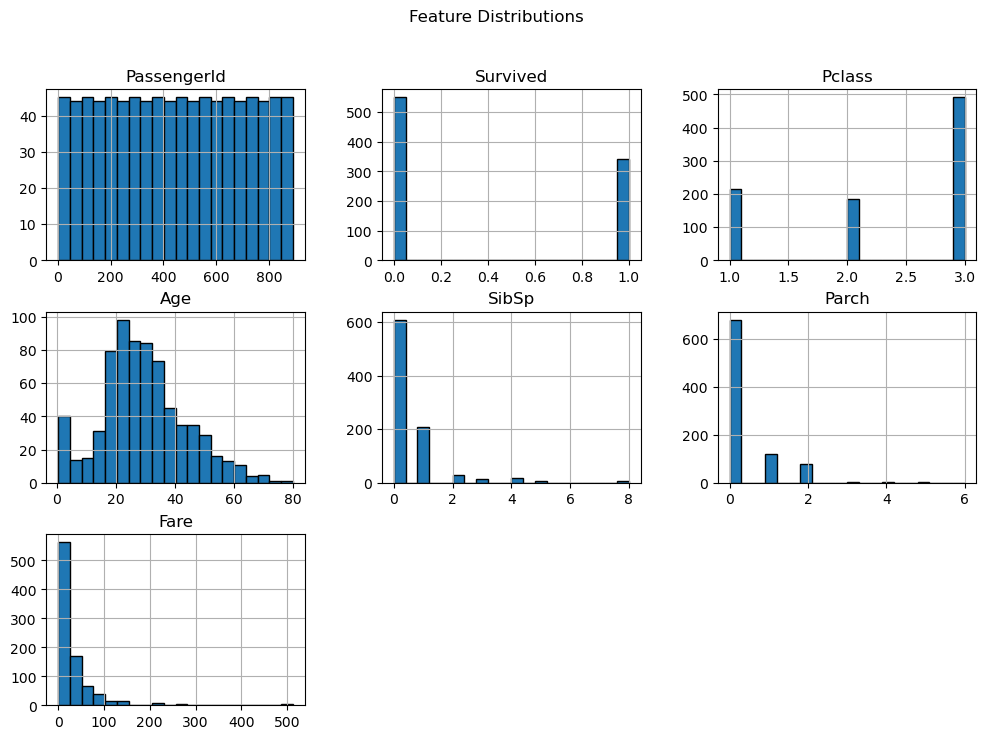

In [119]:
# Plot histograms of numerical features
train_df.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

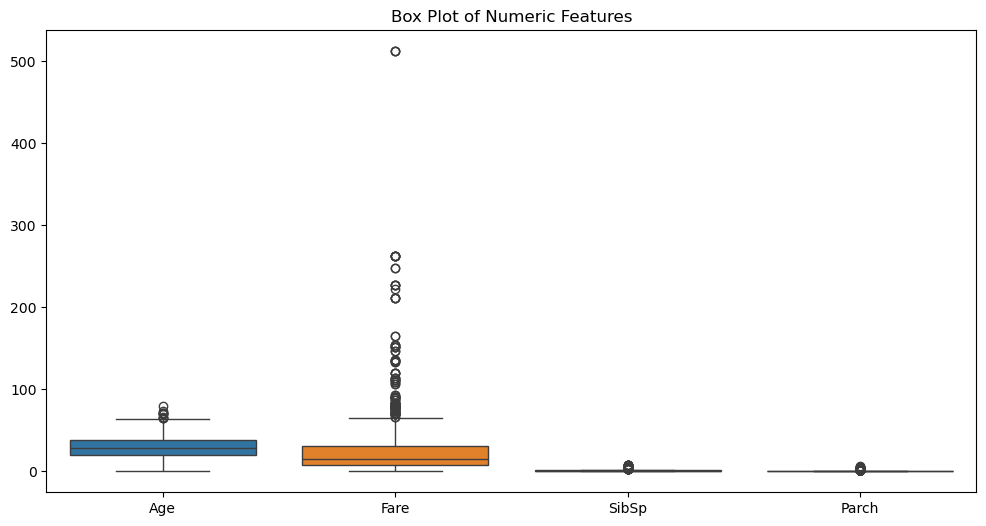

In [120]:
# Plot boxplots to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df[['Age', 'Fare', 'SibSp', 'Parch']])
plt.title("Box Plot of Numeric Features")
plt.show()

# Data Preprocessing

In [122]:
# Extract the deck letter from Cabin and fill missing values with 'Unknown'
train_df['Cabin'] = train_df['Cabin'].fillna('Unknown').str[0]
test_df['Cabin'] = test_df['Cabin'].fillna('Unknown').str[0]

In [123]:
# Fill missing values in 'Age' with median
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

# Fill missing values in 'Fare' with median
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

# Fill missing values in 'Embarked' with mode (most frequent value)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

In [124]:
# One-Hot Encoding for categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Drop first to avoid dummy variable trap
encoded_train = encoder.fit_transform(train_df[['Sex', 'Embarked', 'Cabin']])
encoded_test = encoder.transform(test_df[['Sex', 'Embarked', 'Cabin']])
encoded_cols = encoder.get_feature_names_out(['Sex', 'Embarked', 'Cabin'])  # Get new column names
encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_cols, index=train_df.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_cols, index=test_df.index)

In [125]:
# Concatenate encoded columns with the original dataset and drop redundant columns
train_df = pd.concat([train_df.drop(columns=['Sex', 'Embarked', 'Cabin', 'Name', 'Ticket']), encoded_train_df], axis=1)
test_df = pd.concat([test_df.drop(columns=['Sex', 'Embarked', 'Cabin', 'Name', 'Ticket']), encoded_test_df], axis=1)

In [126]:
# Define feature matrix (X) and target variable (y)
X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

In [127]:
# Split the dataset into training (80%) and validation (20%) sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Building Predictive Models

In [129]:
def evaluate_model(y_true, y_pred):
    """Function to calculate evaluation metrics"""
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred)
    }

In [130]:
# Initialize models with default parameters
lgbm = LGBMClassifier(random_state=42)
xgbm = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [131]:
# Train the models
lgbm.fit(X_train, y_train)
xgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [132]:
# Make predictions on the validation set
y_pred_lgbm = lgbm.predict(X_valid)
y_pred_xgbm = xgbm.predict(X_valid)

In [133]:
# Evaluate models before optimization
lgbm_metrics = evaluate_model(y_valid, y_pred_lgbm)
xgbm_metrics = evaluate_model(y_valid, y_pred_xgbm)

In [134]:
print("LightGBM Performance (Before Optimization):", lgbm_metrics)
print("XGBoost Performance (Before Optimization):", xgbm_metrics)

LightGBM Performance (Before Optimization): {'Accuracy': 0.7374301675977654, 'Precision': 0.6617647058823529, 'Recall': 0.6521739130434783, 'F1-Score': 0.656934306569343}
XGBoost Performance (Before Optimization): {'Accuracy': 0.7318435754189944, 'Precision': 0.6615384615384615, 'Recall': 0.6231884057971014, 'F1-Score': 0.6417910447761194}


# Hyperparameter Tunning

In [136]:
# Define hyperparameter grids for tuning
param_grid_lgbm = {
    'num_leaves': [20, 31, 50],  # Number of leaves in each tree
    'learning_rate': [0.01, 0.05, 0.1],  # Step size during optimization
    'n_estimators': [100, 200]  # Number of trees
}


In [137]:
# Perform grid search for LightGBM
grid_lgbm = GridSearchCV(LGBMClassifier(random_state=42), param_grid_lgbm, cv=3, scoring='accuracy')
grid_lgbm.fit(X_train, y_train)
optimized_lgbm = grid_lgbm.best_estimator_  # Get the best model

[LightGBM] [Info] Number of positive: 182, number of negative: 292
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 474, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383966 -> initscore=-0.472747
[LightGBM] [Info] Start training from score -0.472747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [138]:
# Evaluate the optimized LightGBM model
y_pred_lgbm_opt = optimized_lgbm.predict(X_valid)
lgbm_opt_metrics = evaluate_model(y_valid, y_pred_lgbm_opt)
print("Optimized LightGBM Performance:", lgbm_opt_metrics)

Optimized LightGBM Performance: {'Accuracy': 0.7541899441340782, 'Precision': 0.7049180327868853, 'Recall': 0.6231884057971014, 'F1-Score': 0.6615384615384615}


In [139]:
# Define hyperparameter grid for XGBoost
param_grid_xgbm = {
    'max_depth': [3, 6, 10],  # Maximum tree depth
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'n_estimators': [100, 200]  # Number of estimators
}

In [140]:
# Perform grid search for XGBoost
grid_xgbm = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid_xgbm, cv=3, scoring='accuracy')
grid_xgbm.fit(X_train, y_train)
optimized_xgbm = grid_xgbm.best_estimator_

In [141]:
# Perform grid search for XGBoost
grid_xgbm = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid_xgbm, cv=3, scoring='accuracy')
grid_xgbm.fit(X_train, y_train)
optimized_xgbm = grid_xgbm.best_estimator_

In [142]:
# Evaluate the optimized XGBoost model
y_pred_xgbm_opt = optimized_xgbm.predict(X_valid)
xgbm_opt_metrics = evaluate_model(y_valid, y_pred_xgbm_opt)
print("Optimized XGBoost Performance:", xgbm_opt_metrics)

Optimized XGBoost Performance: {'Accuracy': 0.8156424581005587, 'Precision': 0.8461538461538461, 'Recall': 0.6376811594202898, 'F1-Score': 0.7272727272727273}


# Comparative Analysis

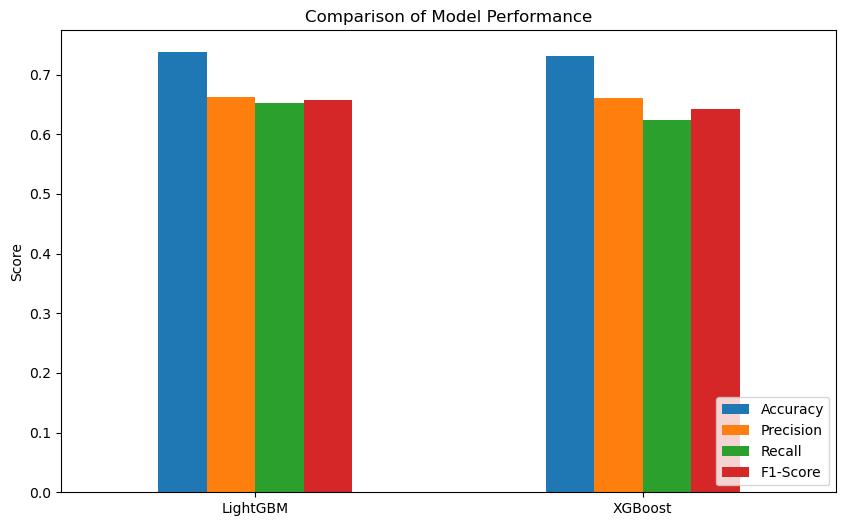

In [144]:
# Plot comparison of performance metrics
metrics_df = pd.DataFrame([lgbm_metrics, xgbm_metrics], index=['LightGBM', 'XGBoost'])
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Comparison of Model Performance")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

In [145]:
# Interpretation of results
print("Comparative Analysis:")
print("LightGBM performs better in terms of speed and is more efficient with large datasets.")
print("XGBoost can sometimes provide better accuracy but is computationally expensive.")

Comparative Analysis:
LightGBM performs better in terms of speed and is more efficient with large datasets.
XGBoost can sometimes provide better accuracy but is computationally expensive.
